# Aperiodic Activity

Changes in aperiodic activity can influence measures of oscillations.

### Issue

Neural activity contains both periodic and aperiodic activity. Aperiodic neural activity is both ubiquitously present, and also dynamic, which can be a confounding factor for many analyses. Measured changes at a particular frequency range could reflect a change or either periodic or aperiodic activity, and cannot be assumed to necessarily reflect changes in periodic activity. 

### Solution

Both periodic and aperiodic activity can be explicitly measured and compared, allowing for careful adjudication of which aspect of the data is changing. 

### Related Work

The following papers include discussion of this topic:
- [Scale-free brain activity: past, present, and future](https://doi.org/10.1016/j.tics.2014.04.003), He B., 2014
- [Simulated power spectral density (PSD) of background electrocorticogram (ECoG)](https://doi.org/10.1007/s11571-008-9064-y), Freeman & Zhai, 2009
- [Co-Increasing Neuronal Noise and Beta Power in the Developing Brain](https://doi.org/10.1101/839258), He W et al, preprint

### Related Discussion / Examples

- Conflating changes in periodic and aperiodic activity in the power spectrum
    - https://fooof-tools.github.io/fooof/auto_motivations/measurements/plot_PeriodicAperiodicFeatures.html
- Filtering aperiodic activity, with changes in aperiodic
    - https://fooof-tools.github.io/fooof/auto_motivations/concepts/plot_IfYouFilterTheyWillCome.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.utils import trim_spectrum
from fooof.analysis import get_band_peak_fm
from fooof.plts.spectra import plot_spectra_shading

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import compute_abs_power, compute_rel_power, rotate_sig
from plts import plot_band_changes, plot_bar, style_psd, savefig
from settings import ALPHA_RANGE, ALPHA_COLOR, COND_COLORS, BAND_COLORS
from settings import BANDS_FULL as BANDS

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Define general simulation settings
n_seconds = 50
fs = 1000
times = create_times(n_seconds, fs)

In [6]:
# Define parameters for the simulations
cf = 10
exp = -1.0
ap_filt = (1.5, 100)

In [7]:
# Define the components of the combined signal
comps = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
         'sim_oscillation' : {'freq' : cf}}

# Define relative power of the signal components
comp_vars = [1, 0.6]

In [8]:
# Analysis settings
nperseg = 1. * fs

In [9]:
# Initialize spectral parameterization object
fm = FOOOF(verbose=False)

In [10]:
# Set range for power spectra
psd_range = [3, 50]

In [11]:
# Plot settings
plt_kwargs = {'alpha' : [0.6, 0.6], 'xlabel' : '', 'ylabel' : ''}
colors = ['black', 'red']
shade_colors = [BAND_COLORS[band] for band in BANDS.labels]

In [12]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate Aperiodic Signals

First, we will simulate some examples of purely aperiodic signals, with no periodic activity. 

For these example signals, we will simulate 'colored noise', including white noise and pink noise. 

In [13]:
# Simulate white and pink noise aperiodic time series
sig_wn = sim_powerlaw(n_seconds, fs, exponent=-0.)
sig_pn = sim_powerlaw(n_seconds, fs, exponent=-1.)

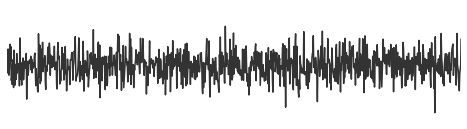

In [14]:
# Plot white noise time series
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, sig_wn, xlim=[4, 5], colors='black', alpha=0.8, lw=1.5, ax=ax)
plt.xticks([]); plt.yticks([]); plt.axis('off');
savefig(SAVE_FIG, '03-ts_white_noise')

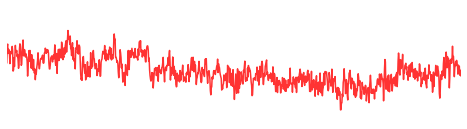

In [15]:
# Plot pink noise time series
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, sig_pn, xlim=[4, 5], colors='red', alpha=0.8, lw=1.5, ax=ax)
plt.xticks([]); plt.yticks([]); plt.axis('off');
savefig(SAVE_FIG, '03-ts_pink_noise')

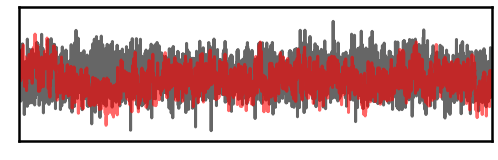

In [16]:
# Plot overlapping time series of the white and pink noise, to compare
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, [sig_wn, sig_pn], xlim=[4, 8], **plt_kwargs, ax=ax)
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '03-ts_noise')

#### Examine Power Spectra & Filtered Traces

Using these aperiodic signals, lets examine their power spectra and some filtered traces. 

In [17]:
# Compute power spectra for the aperiodic time series
freqs, powers_wn = trim_spectrum(*compute_spectrum(sig_wn, fs, nperseg=nperseg), psd_range)
freqs, powers_pn = trim_spectrum(*compute_spectrum(sig_pn, fs, nperseg=nperseg), psd_range)

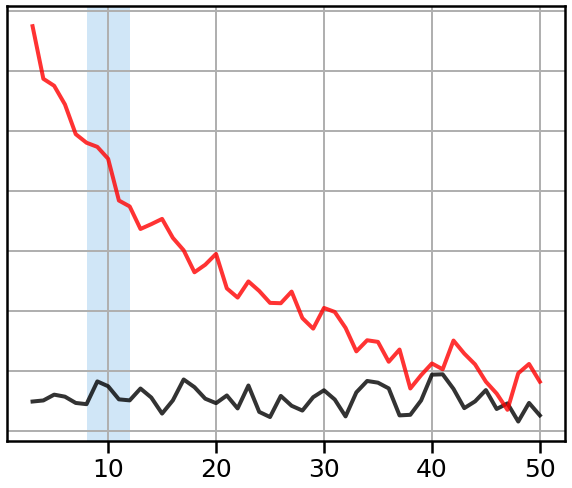

In [18]:
# Plot power spectra of aperiodic signals
plot_spectra_shading(freqs, [powers_wn, powers_pn], ALPHA_RANGE,
                     log_powers=True, lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=colors, line_alpha=0.8)
savefig(SAVE_FIG, '03-psd_noise')

As we can see in the above, aperiodic signals have power across all frequencies, though without any prominent peaks. 

In [19]:
# Filter aperiodic signals to alpha range
sig_filt_wn = filter_signal(sig_wn, fs, 'bandpass', ALPHA_RANGE)
sig_filt_pn = filter_signal(sig_pn, fs, 'bandpass', ALPHA_RANGE)

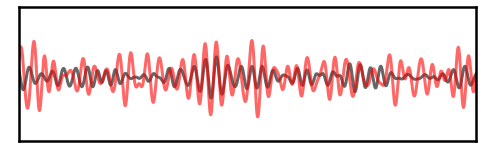

In [20]:
# Plot alpha filtered aperiodic signals
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, [sig_filt_wn, sig_filt_pn], 
                 xlim=[4, 8], **plt_kwargs, ax=ax)
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '03-ts_noise_filt')

In the filtered traces above, we can see that narrowband filtered traces look to be rhythmic. 

Additionally, the amount of rhythmic power varies based on the character of the simulated aperiodic signal. 

## Simulate signals with oscillations

Next, let's examine combined signals, simulated with both aperiodic and periodic activity. 

In [21]:
# Simulate a combined signal
sig = sim_combined(n_seconds, fs, comps, comp_vars)

In [22]:
# Define settings for rotating the signal
exp_rot = -0.35
f_rotation = 25

In [23]:
# Rotate signal
sig_rot = rotate_sig(sig, fs, exp_rot, f_rotation)

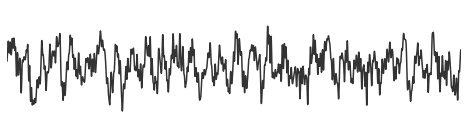

In [24]:
# Plot original signal
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, sig, xlim=[4, 7], colors='black', alpha=0.8, lw=1.5, ax=ax)
plt.axis('off');
savefig(SAVE_FIG, '03-ts_signal')

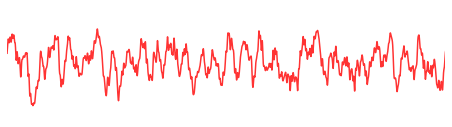

In [25]:
# Plot rotated signal
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, sig_rot, xlim=[4, 7], colors='red', alpha=0.8, lw=1.5, ax=ax)
plt.axis('off');
savefig(SAVE_FIG, '03-ts_signal_rot')

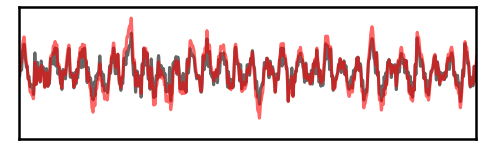

In [26]:
# Plot both signals overlaid
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, [sig, sig_rot], xlim=[1, 4], **plt_kwargs, ax=ax)
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '03-ts_full')

In [27]:
# Filter signals to the alpha range
sig_filt = filter_signal(sig, fs, 'bandpass', ALPHA_RANGE)
sig_rot_filt = filter_signal(sig_rot, fs, 'bandpass', ALPHA_RANGE)

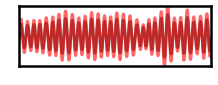

In [28]:
# Plot filtered signals
_, ax = plt.subplots(figsize=(4, 2))
plot_time_series(times, [sig_filt, sig_rot_filt],
                 xlim=[1, 4], ylim=[-2.15, 2.15],
                 **plt_kwargs, ax=ax)
plt.xticks([]); plt.yticks([]);
savefig(SAVE_FIG, '03-ts_filt')

### Compare power spectra

In [29]:
# Compute power spectra 
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig_rot, fs, nperseg=nperseg), psd_range)

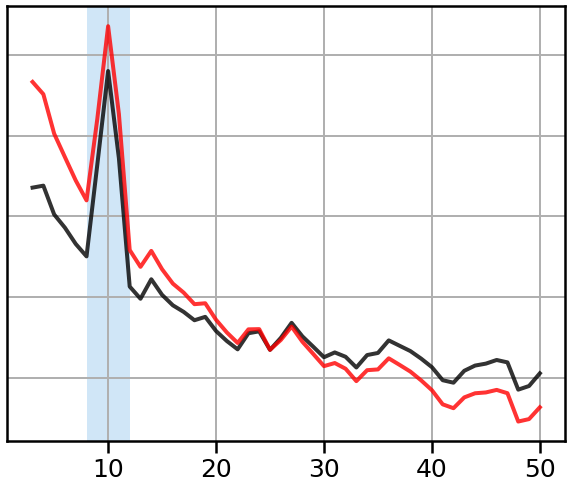

In [30]:
# Plot power spectra
plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=colors, line_alpha=0.8)
savefig(SAVE_FIG, '03-psd_osc')

## Band-by-Band Comparisons

In the next example, we will compare the results of a band-by-band analysis. 

To do so, we will compare data in which the actual change is a change in the aperiodic component of the data (a spectral rotation). 

In [31]:
# Define settings for rotating the signal
exp_rot = -0.5
f_rotation = 10

In [32]:
# Simulate a new combined signal
sig1 = sim_combined(n_seconds, fs, comps, comp_vars)

In [33]:
# Create the second signal as a spectrally rotated version of the first
sig2 = rotate_sig(sig1, fs, exp_rot, f_rotation)

In [34]:
# Calculate power spectra
freqs1_pl, powers1_pl = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=nperseg), [2, 50])
freqs2_pl, powers2_pl = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=nperseg), [2, 50])

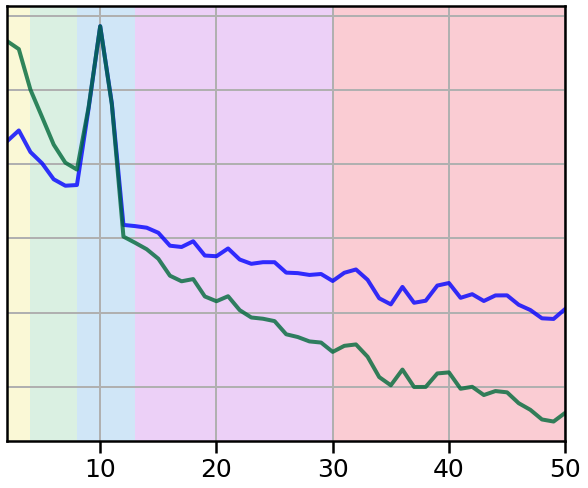

In [35]:
# Plot power spectra of the two signals
plot_spectra_shading(freqs1_pl, [powers1_pl, powers2_pl], 
                     BANDS.definitions, shade_colors,
                     lw=4, log_powers=True)
style_psd(plt.gca(), line_colors=COND_COLORS, line_alpha=0.8)
plt.xlim([2, 50])
savefig(SAVE_FIG, '03-psd_bands_rotation')

In [36]:
# Compute power spectra for each spectrum
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs), [2, 80])
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs), [2, 80])

In [37]:
# Compute the measured differences in band power between spectra
deltas = {}
for label, f_range in BANDS:
    deltas[label] = compute_abs_power(freqs1, powers1, f_range) - \
        compute_abs_power(freqs2, powers2, f_range)

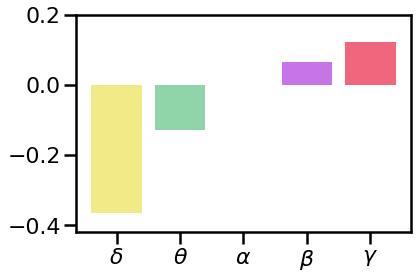

In [38]:
# Plot measured differences in power across bands
plot_band_changes(deltas, colors=shade_colors, ylim=[-0.42, 0.2])
savefig(SAVE_FIG, '03-bands_changes')

## Relative Power Comparisons

Next, we will examine a relative power analysis on the same data from above. 

In [39]:
# Define 'full range' of the PSD to use for power measures
full_range = [2, 50]

In [40]:
# Compute absolute power of alpha
abs1 = compute_abs_power(freqs1, powers1, ALPHA_RANGE)
abs2 = compute_abs_power(freqs2, powers2, ALPHA_RANGE)

In [41]:
# Print out absolute alpha measures
print('Absolute alpha - sig1 : {:8.4f}'.format(abs1))
print('Absolute alpha - sig2 : {:8.4f}'.format(abs2))

Absolute alpha - sig1 :   0.4598
Absolute alpha - sig2 :   0.4640


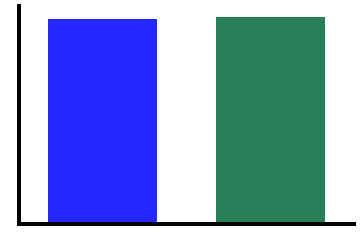

In [42]:
# Plot the absolute power of alpha
plot_bar(abs1, abs2, color=COND_COLORS, alpha=0.85)
savefig(SAVE_FIG, '03-pow_abs_alpha')

In [43]:
# Compute total power for each signal
tot1 = compute_abs_power(freqs1, powers1, full_range)
tot2 = compute_abs_power(freqs2, powers2, full_range)

In [44]:
# Print out total power measures
print('Total power - sig1 : {:8.4f}'.format(tot1))
print('Total power - sig2 : {:8.4f}'.format(tot2))

Total power - sig1 :   0.9017
Total power - sig2 :   1.2030


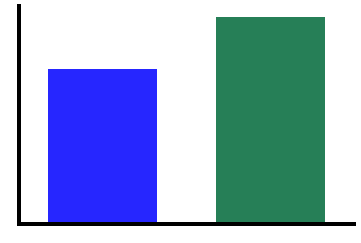

In [45]:
# Plot the total power
plot_bar(tot1, tot2, color=COND_COLORS, alpha=0.85)
savefig(SAVE_FIG, '03-pow_tot')

In [46]:
# Compute relative power of alpha for each signal
rel1 = compute_rel_power(freqs1, powers1, ALPHA_RANGE, norm_range=full_range)
rel2 = compute_rel_power(freqs2, powers2, ALPHA_RANGE, norm_range=full_range)

In [47]:
# Print out relative alpha measures
print('Relative alpha - sig1 : {:8.4f}'.format(rel1))
print('Relative alpha - sig2 : {:8.4f}'.format(rel2))

Relative alpha - sig1 :  50.9946
Relative alpha - sig2 :  38.5705


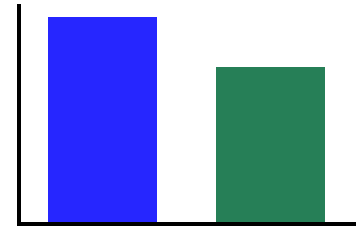

In [48]:
# Plot the relative power of alpha
plot_bar(rel1, rel2, color=COND_COLORS, alpha=0.85)
savefig(SAVE_FIG, '03-pow_rel_alphs')

### Spectral Parameterization

As we've seen above, band-by-band or relative power analyses can give confounded results when there are aperiodic changes in the data. 

An alternative analysis approach, that specifically characterizes periodic and aperiodic changes in the data is [spectral parameterization](https://fooof-tools.github.io/). 

In [49]:
# Initialize model objects for spectral parameterization
fm1 = FOOOF(verbose=False)
fm2 = FOOOF(verbose=False)

# Parameterize the spectra for each signal
fm1.fit(freqs1_pl, powers1_pl, psd_range)
fm2.fit(freqs2_pl, powers2_pl, psd_range)

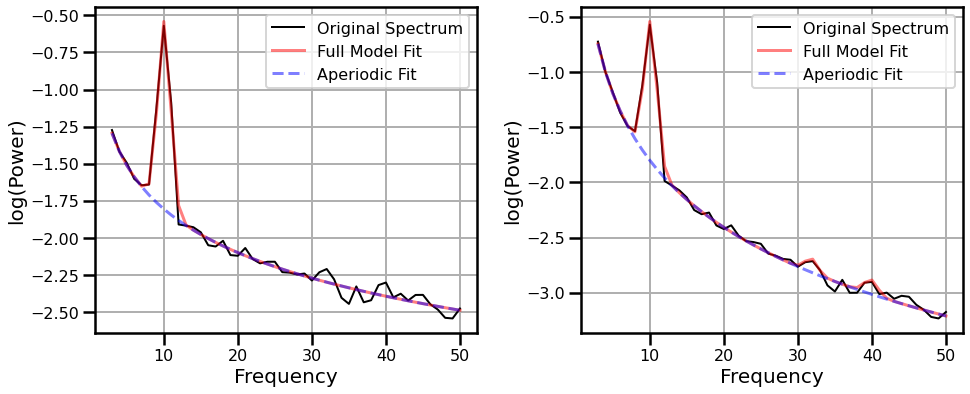

In [50]:
# Plot the power spectra with the model results for each signal
_, axes = plt.subplots(1, 2, figsize=(14, 6))
fm1.plot(ax=axes[0])
fm2.plot(ax=axes[1])
plt.tight_layout()

In [51]:
# Get the measured alpha parameters
alpha1 = get_band_peak_fm(fm1, ALPHA_RANGE)
alpha2 = get_band_peak_fm(fm2, ALPHA_RANGE)

In [52]:
# Compare the measured alpha peaks between signals
print('Alpha peak - signal 1:  CF: {:4.2f},  PW: {:4.2f},  BW: {:4.2f}'.format(*alpha1))
print('Alpha peak - signal 2:  CF: {:4.2f},  PW: {:4.2f},  BW: {:4.2f}'.format(*alpha2))

Alpha peak - signal 1:  CF: 10.06,  PW: 1.26,  BW: 1.73
Alpha peak - signal 2:  CF: 10.10,  PW: 1.26,  BW: 1.71


In [53]:
# Get the measured aperiodic exponent parameters
exp1 = fm1.get_params('aperiodic', 'exponent')
exp2 = fm2.get_params('aperiodic', 'exponent')

In [54]:
# Compare the measured aperiodic exponent between signals
print('Aperiodic exponent - signal 1: {:8.4f}'.format(exp1))
print('Aperiodic exponent - signal 2: {:8.4f}'.format(exp2))

Aperiodic exponent - signal 1:   0.9756
Aperiodic exponent - signal 2:   2.0171


With spectral parameterization, we are able to see that the change in the data is in the aperiodic exponent, and that there is no change in periodic activity.

More information on spectral parameterization is available [here](https://fooof-tools.github.io/). 

## Conclusion

Neural recordings contains aperiodic activity, which is itself dynamic. 

Analysis of neural data needs to consider variability of aperiodic activity, and employ robust measures that reflect when changes are in periodic and/or aperiodic activity. 